In [5]:
#  数据增强，精准切片
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import pprint

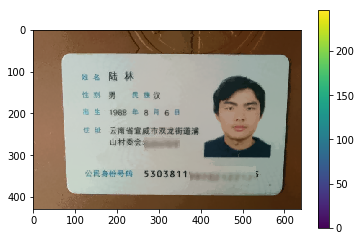

In [6]:
# 第一步：读取数据
# image = cv2.imread("beer.jpg",1)
# image = cv2.imread("tiGas.jpg",1) # 高斯后的图片
image = cv2.imread("ti.jpg",1)
# print(image.mod)
# 第二步：降噪避免误测
image = cv2.pyrMeanShiftFiltering(image, 35, 10)

image_Plt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_Plt)
plt.colorbar()
plt.show()

In [52]:
image_shape

(428, 640, 3)

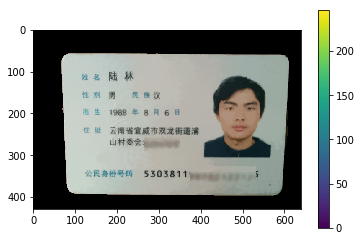

In [62]:
# 第三步：前后背景分离
mask = np.zeros(image.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
# image shape=398, 299

# rect = (50,50,image_shape[0]-50,image_shape[1]-50)
image_shape = image.shape
rect = (50,50,image_shape[1]-20,image_shape[0]-20)

cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
image = image*mask2[:,:,np.newaxis]
image_plt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_plt)
plt.colorbar()
plt.show()

In [54]:
rect

(50, 50, 620, 408)

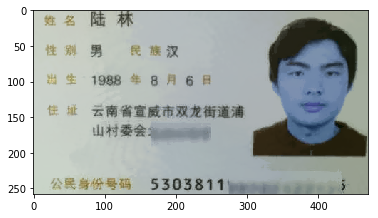

In [55]:
need_gas = image[100: image_shape[0]-70,100: image_shape[1]-70]
plt.imshow(need_gas)
plt.show()


(258, 470, 3)


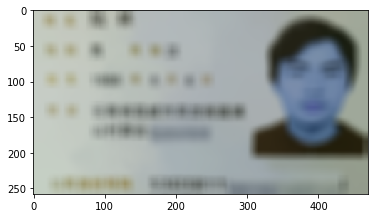

In [56]:
# 均值化处理，最大类似池化
need_gas2 = need_gas[::30,::30]
# 高斯模糊处理
need_gas3 = cv2.GaussianBlur(need_gas, (15,15), 20)
plt.imshow(need_gas3)
print(need_gas3.shape)

In [57]:
gas_m = image_plt.copy()
for i in range(258):
    for j in range(470):     #打了马赛克的头部图像的列数
        # 把打了马赛克图像的像素点替换原图像对应的像素点
#         gas_m[100+i*30:130+i*30,100+j*30:130+j*30] = need_gas2[i,j]
        gas_m[100+ i ,100+ j] = need_gas3[i,j]

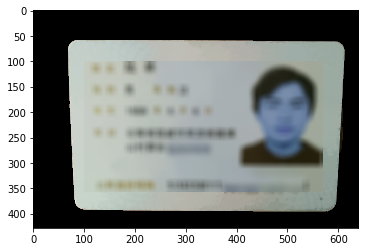

In [58]:
plt.imshow(gas_m)

In [59]:

gas_m = cv2.GaussianBlur(gas_m, (5,5), 10)

In [61]:
ret,thresh = cv2.threshold(gas_m,100,255,0)
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
con = cv2.drawContours(im, contours, -1,(255,25,0), 1)
# hie = cv2.drawContours(im, hierarchy,-1,(0,255,0),3)
# cv2.imshow('hie',hie)

cv2.imshow('im',im)
cv2.imshow('con',con)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 

cv2.imwrite('im.jpg',im)

cv2.waitKey(0) 
cv2.destroyAllWindows()

error: OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\imgproc\src\contours.cpp:199: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [38]:
# 提起边 cv2.HoughLinesP

edges = cv2.Canny(gas_m,100,200) 
# minLineLengh，线的最短长度，MaxLineCap，两条直线之间的最大间隔
lines = cv2.HoughLinesP(edges, 1.0, np.pi/180, 100, minLineLength=100, maxLineGap=100)

lines1 = lines[:,0,:]#提取为二维
for x1,y1,x2,y2 in lines1[:]: 
    cv2.line(image_plt, (x1,y1), (x2,y2), (0,0,255),1)
     
cv2.imshow('image',image)    
cv2.imshow('edges',edges)
cv2.imshow('image_plt',image_plt)
cv2.waitKey(0)
cv2.destroyAllWindows()

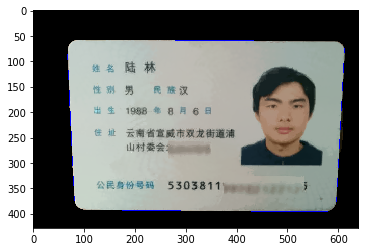

In [37]:
plt.imshow(image_plt)


In [36]:
print(lines1)
# print('lines_shape is {}'.format(lines1.shape))
print(f'lines_shape is {lines1.shape}')

[[ 82  58 299  58]
 [433  60 591  60]
 [278  59 432  59]
 [595 376 611  75]
 [427 395 579 395]
 [291 394 426 394]
 [175 393 290 393]
 [ 67  87  75 248]
 [ 71 178  81 374]]
lines_shape is (9, 4)


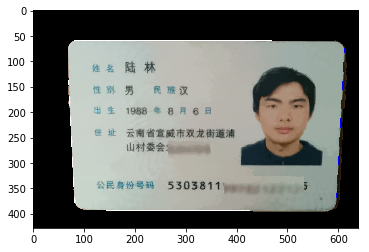

In [193]:
lines2= lines1[0:4]
lines2

for x1,y1,x2,y2 in lines2[:]: 
    cv2.line(image_plt,(x1,y1),(x2,y2),(255,255,255),1)
plt.imshow(image_plt)

In [195]:
# 做点检查
gray = cv2.cvtColor(gas_m, cv2.COLOR_BGR2GRAY)
gray  = np.float32(gray)
corners = cv2.goodFeaturesToTrack(gray, 16, 0.01, 10)
corners = np.int0(corners) 
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(image, (x, y), 3, 255, -1)

In [196]:
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [155]:
# 第四步：高斯模糊对于的区域
corners.shape

(8, 1, 2)

In [17]:
# 显示边缘，
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) 
lower_red = np.array([30,150,50]) 
upper_red = np.array([255,255,180]) 
mask = cv2.inRange(hsv, lower_red, upper_red) 
res = cv2.bitwise_and(image,image, mask= mask) 
laplacian = cv2.Laplacian(image,cv2.CV_64F) 
sobelx = cv2.Sobel(image,cv2.CV_64F,1,0,ksize=5) 
sobely = cv2.Sobel(image,cv2.CV_64F,0,1,ksize=5) 
edges = cv2.GaussianBlur(image, (7,7), 0)
edges = cv2.Canny(edges,100,200) 

cv2.imshow('Original',image) 
# cv2.imshow('Mask',mask) 
# cv2.imshow('laplacian',laplacian) 
# cv2.imshow('sobelx',sobelx) 
# cv2.imshow('sobely',sobely) 
cv2.imshow('edges',edges) 
    
cv2.waitKey(0)
cv2.destroyAllWindows()
# cap.release()

# plt.subplot(2,1,1)

# edges_plt = cv2.cvtColor(edges, cv2.COLOR_HSV2RGB)
# plt.imshow(edges)
# plt.colorbar()
# plt.subplot(2,1,2)
# plt.imshow(image)   
# plt.show()


In [60]:
import cv2

imgName = "0.jpg"
kernel_size = (15, 15)
sigma1 = 10
sigma2 = 5

img = cv2.imread(imgName)
# 高斯模糊
img1 = cv2.GaussianBlur(img, kernel_size, sigma1)
img2 = cv2.GaussianBlur(img, kernel_size, sigma2)

cv2.imshow('img', img)
cv2.imshow('img1', img1) 
cv2.imshow('img2', img2) 

cv2.waitKey(0)
cv2.destroyAllWindows()
cap.release()


In [ ]:
findContours
Canny

([], <a list of 0 Text yticklabel objects>)

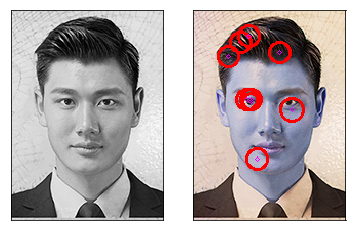

In [133]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('for_eye.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)#灰度图像 

plt.subplot(121),
plt.imshow(gray,'gray')
plt.xticks([]),
plt.yticks([])
#hough transform
circles1 = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT,1, 1, param1=20, param2=20, minRadius=5, maxRadius=15)
circles = circles1[0,:,:]#提取为二维
circles = np.uint16(np.around(circles))#四舍五入，取整
for i in circles[:]: 
    cv2.circle(img,(i[0],i[1]),i[2],(255,0,0),2)#画圆
    cv2.circle(img,(i[0],i[1]),2,(255,0,255),1)#画圆心

plt.subplot(122)
plt.imshow(img)
plt.xticks([])
plt.yticks([])

In [39]:
def cross_point(line1,line2):#计算交点函数
    x1=line1[0]#取四点坐标
    y1=line1[1]
    x2=line1[2]
    y2=line1[3]
    print(x1,y1,x2,y2)
    
    x3=line2[0]
    y3=line2[1]
    x4=line2[2]
    y4=line2[3]
    print(x3,y3,x4,y4)

    
    k1=(y2-y1)*1.0/(x2-x1)#计算k1,由于点均为整数，需要进行浮点数转化
    b1=y1*1.0-x1*k1*1.0#整型转浮点型是关键
    if (x4-x3)==0:#L2直线斜率不存在操作
        k2=None
        b2=0
    else:
        k2=(y4-y3)*1.0/(x4-x3)#斜率存在操作
        b2=y3*1.0-x3*k2*1.0
    if k2==None:
        x=x3
    else:
        x=(b2-b1)*1.0/(k1-k2)
    y=k1*x*1.0+b1*1.0
    return [int(x), int(y)]
 

In [40]:
lines2 = lines1.tolist()
for ii in lines2:
    if ii[1] == ii[3]:
        lines2.remove(ii)


In [42]:
lines

array([[[ 82,  58, 299,  58]],

       [[433,  60, 591,  60]],

       [[278,  59, 432,  59]],

       [[595, 376, 611,  75]],

       [[427, 395, 579, 395]],

       [[291, 394, 426, 394]],

       [[175, 393, 290, 393]],

       [[ 67,  87,  75, 248]],

       [[ 71, 178,  81, 374]]], dtype=int32)

In [43]:
lines2

[[433, 60, 591, 60],
 [595, 376, 611, 75],
 [291, 394, 426, 394],
 [67, 87, 75, 248],
 [71, 178, 81, 374]]

In [1]:
# pin1 = cross_point(lines2[0],lines1[4])
# pin2 = cross_point(lines2[0],lines1[3])
# pin3 = cross_point(lines2[1],lines1[4])
# pin4 = cross_point(lines2[1],lines1[3])
# print(pin1,pin2,pin3,pin4)

In [3]:
keypoints = [[611, 59] [65, 59] [593, 394] [81, 394]]
cv2.drawKeypoints(image, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [228]:
lines1

array([[ 80,  59, 469,  59],
       [295, 394, 581, 394],
       [143, 393, 425, 393],
       [ 69, 137,  81, 377],
       [595, 369, 611,  75],
       [ 84,  58, 361,  58],
       [275,  60, 594,  60],
       [ 97, 392, 286, 392]], dtype=int32)

In [8]:
# [611, 59] [65, 59] [593, 394] [81, 394]
image = cv2.imread("ti.jpg",1)
corners = np.float32([[68, 59],[611,61],[581, 377],[81,377]])
canvas = np.float32([[0, 0],[600, 0],[600,400],[0,400]])
M = cv2.getPerspectiveTransform(corners, canvas)
result = cv2.warpPerspective(image, M, (0, 0))
cv2.imshow("result", result)
cv2.imshow("image_Plt", image_Plt)
cv2.waitKey(0)
cv2.destroyAllWindows()